# Установка зависимостей

In [ ]:
!pip install tqdm

In [ ]:
# Установка библиотеки для симуляции мячика dynamic_sys
!pip install git+https://github.com/AMGureev/dynamic_sys.git

  Cloning https://github.com/AMGureev/dynamic_sys.git to /tmp/pip-req-build-j6fz3dg4
  Running command git clone --filter=blob:none --quiet https://github.com/AMGureev/dynamic_sys.git /tmp/pip-req-build-j6fz3dg4
  Resolved https://github.com/AMGureev/dynamic_sys.git to commit 4788c93803414e4f6425cb03715a449145997988
  Preparing metadata (setup.py) ... done
  Created wheel for dynamic-sys: filename=dynamic_sys-0.0.10-py3-none-any.whl size=4460 sha256=66ccb65b29acaa3389af3a3571718ba623a2cd3fe014917f24da7fed35ba90bf
  Stored in directory: /tmp/pip-ephem-wheel-cache-p4k3uefu/wheels/e4/18/4d/d32060722cdb835ab357aeeb56d6fd390dbf350e04cb447d16
Successfully built dynamic-sys


In [ ]:
import keras.models
import matplotlib.pyplot as plt
import numpy as np
import random as r
import tensorflow as tf
from dynamic_sys import BallMagSystem, DataGen
from keras.layers import Add, Concatenate, Dense, Flatten, Input, Lambda, Multiply, Subtract
from tqdm import tqdm
from tqdm.keras import TqdmCallback

# Динамическая система

Динамическая система — множество элементов, для которого задана функциональная зависимость между временем и положением в фазовом пространстве каждого элемента системы.  \\
В данной работе мы будем использовать движение мячика в магнитном поле, чье положение зависит от величины, подаваемого на электромагнит напряжения. Сама система реализована в `dynamic_sys`.

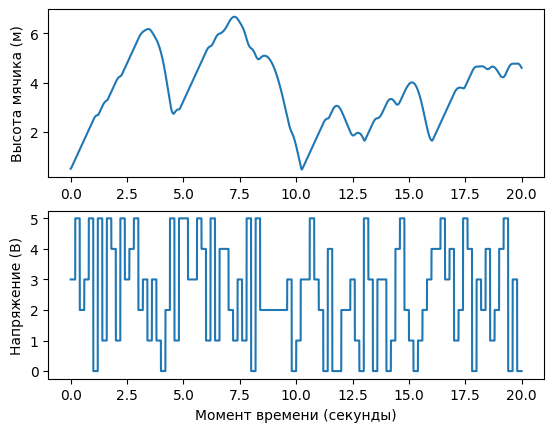

In [ ]:
# Количество шагов симуляции
steps = 20_000
# Изменение времени с каждым шагом симуляции
dt = 0.001

# Создать массив напряжений для обучающих данных
volt_data = DataGen.voltages_float(steps, 200)
# Создать массив напряжений для тестовых данных
volt_data0 = DataGen.voltages_float(steps, 200)

# Создание экземпляра класса для симуляции системы
system = BallMagSystem()
# Создать обучающий массив высоты мячика
pos_data = BallMagSystem.valid_results(system, volt_data, dt)
# Создание экземпляра класса для симуляции системы (обнуление системы)
system = BallMagSystem()
# Создать тестовый массив высоты мячика
pos_data0 = BallMagSystem.valid_results(system, volt_data0, dt)

# Выведем графики высоты мячика и подаваемого напряжения
lin_space = np.linspace(0, steps * dt, steps)
plt.subplot(2, 1, 1)
plt.plot(lin_space, pos_data0)
plt.ylabel('Высота мячика (м)')  # Установка подписи оси y
plt.subplot(2, 1, 2)
plt.plot(lin_space, volt_data0)
plt.xlabel('Момент времени (секунды)')  # Установка подписи оси x
plt.ylabel('Напряжение (В)')  # Установка подписи оси y
plt.show()

# ПИД-контроллер

ПИД-контроллер (Proportional-Integral-Derivative controller) является одним из наиболее распространенных типов контроллеров в автоматическом управлении. Он широко применяется в различных областях, где требуется точное управление системами, такими как температурные процессы, скорость двигателей, позиционирование в системах автоматического управления и многие другие.

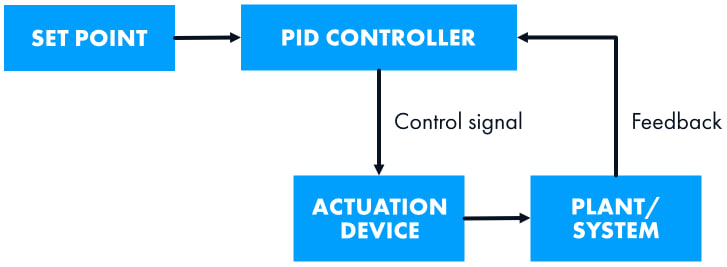

1. Пропорциональная составляющая (P):

   Пропорциональное действие регулятора просто умножает текущую ошибку на некоторый коэффициент $K_p$, называемый коэффициентом усиления (gain):
   
  $ P(t) = K_p \cdot e(t) $

   где:
   - $ P(t) $ - пропорциональное действие в момент времени $ t $,
   - $ K_p $ - коэффициент пропорциональности,
   - $ e(t) $ - текущая ошибка (разница между желаемым и текущим значением процесса) в момент времени $ t $.

2. Интегральная составляющая $I$:

   Интегральное действие учитывает накопленную ошибку во времени. Это помогает устранить статическую ошибку и поддерживать систему в равновесии. Интегральное действие равно интегралу от ошибки с учетом коэффициента интегрального действия $ K_i $:
   
   $\ I(t) = K_i \cdot \int_{0}^{t} e(\tau) d\tau \$

   где:
   - $ I(t) $ - интегральное действие в момент времени $ t $,
   - $ K_i $ - коэффициент интегральной составляющей,
   - $ e(\tau) $ - ошибка в момент времени $ \tau $,
   - $ \tau $ - переменная интегрирования.

3. Дифференциальная составляющая $D$:

   Дифференциальное действие предсказывает будущие изменения и позволяет предотвращать резкие изменения в системе. Оно пропорционально скорости изменения ошибки с учетом коэффициента дифференциального действия $ K_d $:
   
   $ D(t) = K_d \cdot \frac{de(t)}{dt} $

   где:
   - $ D(t) $ - дифференциальное действие в момент времени $ t $,
   - $ K_d $ - коэффициент дифференциальной составляющей,
   - $ \frac{de(t)}{dt} $ - производная ошибки по времени.

Таким образом, общее управляющее воздействие ПИД-регулятора на момент времени $ t $ равно сумме пропорционального, интегрального и дифференциального действий:

$ u(t) = P(t) + I(t) + D(t) $

где $ u(t) $ - управляющее воздействие в момент времени $ t $.

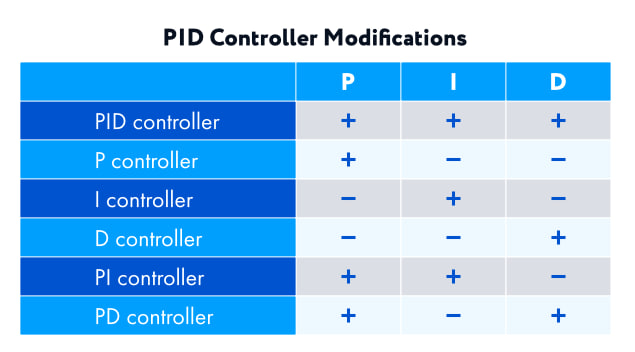

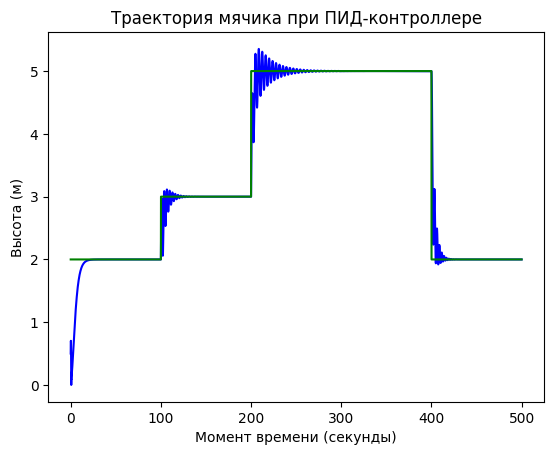

<Figure size 640x480 with 0 Axes>

In [ ]:
#@title {run: "auto"}

# Коэффициент пропорциональной составляющей
Kp = 0.12 #@param {type:"slider", min:0, max:1, step:0.01}
# Коэффициент интегральной составляющей
Ki = 0.18 #@param {type:"slider", min:0, max:1, step:0.01}
# Коэффициент дифференциальной составляющей
Kd = 0.07 #@param {type:"slider", min:0, max:1, step:0.01}

prev_error = 0  # Предыдущая ошибка
integral = 0  # Интеграл ошибок

# Функция для вычисления управляющего сигнала с помощью PID-регулятора
def pid_control(desired_position, current_position):
    global prev_error, integral
    error = desired_position - current_position  # Вычисление текущей ошибки
    integral += error * dt  # Вычисление интеграла ошибок
    derivative = (error - prev_error) / dt  # Вычисление производной ошибки
    prev_error = error  # Обновление предыдущей ошибки
    control_signal = Kp * error + Ki * integral + Kd * derivative  # Вычисление управляющего сигнала
    return control_signal  # Возвращение управляющего сигнала

def run_controller(system, target, iter, dt):
    res = []  # Список для хранения управляющих сигналов
    positions = []  # Список для хранения текущих позиций
    for i in range(iter):
        pos = system.ball_pos  # Получение текущей позиции мячика
        signal = max(0, pid_control(target, pos))  # Вычисление управляющего сигнала и его ограничение
        curr_pos = BallMagSystem.simulated(system, signal)  # Моделирование движения системы с управляющим сигналом
        res.append(signal)  # Добавление управляющего сигнала в список
        positions.append(curr_pos)  # Добавление текущей позиции в список
    return res, positions  # Возвращение списков управляющих сигналов и текущих позиций

# Моделирование движения мячика с применением PID-регулятора
system = BallMagSystem()  # Создание объекта системы с мячиком
res = []  # Список для хранения результатов моделирования
n = 100000  # Количество итераций моделирования
p = 5
# Целевые значения позиции мячика
reference = [2] * n + [3] * n + [5] * n + [5] * n + [2] * n
for s in [2, 3, 5, 5, 2]:
    # Запуск моделирования с управляющим сигналом
    _, positions_pid = run_controller(system, s, n, 0.001)
    res += positions_pid  # Добавление результатов моделирования в общий список

# Отображение траектории движения мячика с применением PID-контроллера
lin_space = np.linspace(0, n * p * dt, n * p)
plt.plot(lin_space, res, color="b")  # Отображение траектории мячика
plt.plot(lin_space, reference, color="g")  # Отображение целевых значений позиции мячика
plt.xlabel('Момент времени (секунды)')  # Установка подписи оси x
plt.ylabel('Высота (м)')  # Установка подписи оси y
plt.title('Траектория мячика при ПИД-контроллере')  # Установка заголовка графика
plt.show()  # Отображение графика
plt.clf()  # Очистка текущего графика


# NARMA-L2

NARMA-L2 (Nonlinear AutoRegressive Moving Average with exogenous inputs - L2 norm) - это тип нелинейного регулятора, который используется для управления динамическими системами.

Процесс получения NARMA-L2 контроллера включает в себя следующие шаги:

1. Первым шагом является выбор структуры модели для использования. Одна из стандартных моделей, используемых для представления общих дискретных нелинейных систем, - это модель нелинейного авторегрессионно-скользящего среднего (NARMA):
$y(k+d)=N(y(k),y(k−1),…,y(k−n+1),u(k),u(k−1),…,u(k−n+1)) $ где $u(k)$ - это вход системы, а $y(k)$ - это выход системы.
2. Далее идет фаза идентификации. Во время нее идет обучение нейронной сети для приближенного представления нелинейной функции N, которая описывает нашу динамическую систему.
4. Далее идет переконфигурация обученной сети таким образом, чтобы на выходе получалось значение, необходимое для согласования диинамической системы с сигналом, подаваемым на вход контроллеру.


Создадим свой NARMA L2 контроллер.
1. Создадим сеть как на рисунке ниже, чей выход просчитывается как $y(t+1) = f(t) + g(t)u(t+1)$, где $f(t), g(t)$ - значения подсетей f и g.

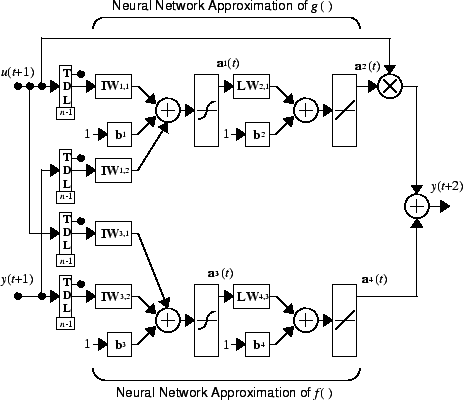

2. Обучим ее эмулировать нашу динамическую систему, подавая на вход в сеть текущее напряжение, предыдущее положение мячика, а на выходе ожидая получить текущее положение мячика.
3. Произведем переконфигурацию сети, как показано на рисунке ниже, чтобы на выход получать  $u(t+1)=\frac{y(t+1)−f(t)g(t)}{u(t)}$ , где  $u(t+1)$  - необходимое напряжение,  $y(t+1)$  - нужное положение мячика, подаваемое на вход сети,  $f(t), g(t)$  - значения выдаваемы подсетями.

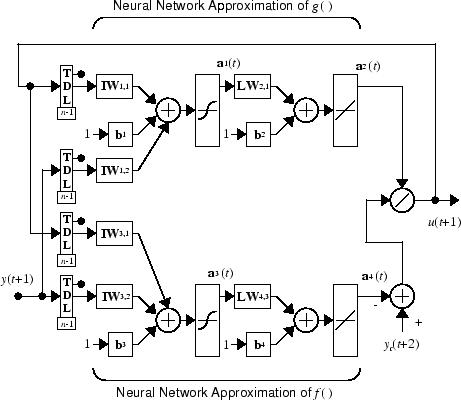

Натренируем сеть предсказывать положение мячика.

Model: "model_76"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_161 (InputLayer)      [(None, 4, 1)]            0         
                                                                 
 flatten_160 (Flatten)       (None, 4)                 0         
                                                                 
 dense_70 (Dense)            (None, 4)                 20        
                                                                 
 dense_71 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Model: "model_77"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_162 (InputLayer)      [(None, 4, 1)]            0         
                                                                 
 flatten_161 (Flatten)       (None, 4)                 0         
                                                                 
 dense_72 (Dense)            (None, 4)                 20        
                                                                 
 dense_73 (Dense)            (None, 1)                 5         
                                                                 
Total params: 25 (100.00 Byte)
Trainable params: 25 (100.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

Model: "model_78"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_164 (InputLayer)      [(None, 4, 1)]               0         []                            
                                                                                                  
 input_165 (InputLayer)      [(None, 1, 1)]               0         []                            
                                                                                                  
 input_163 (InputLayer)      [(None, 4, 1)]               0         []                            
                                                                                                  
 flatten_163 (Flatten)       (None, 4)                    0         ['input_164[0][0]']           
                                                                                           

None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

625/625 [==============================] - 1s 1ms/step


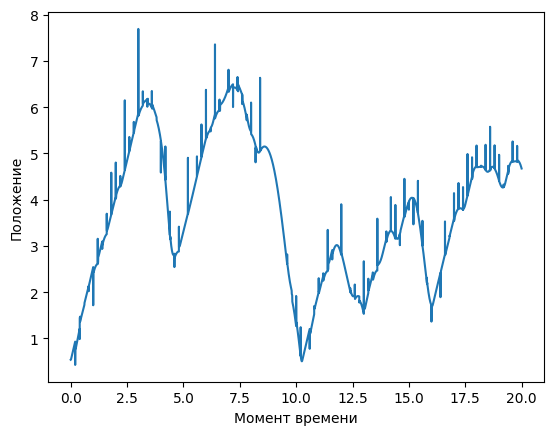

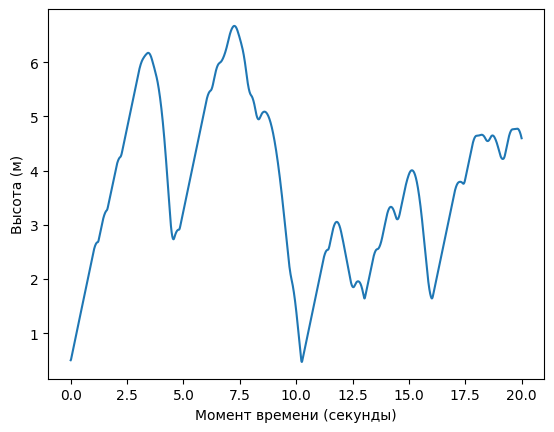

625/625 [==============================] - 1s 1ms/step - loss: 0.0055


0.005548688117414713

In [ ]:
# Тренировка сети для эмуляции поведения мячика

# Создание модели f для обучения
def create_f():
    input_layer_1 = Input((4, 1))  # Входной слой модели
    # Преобразование входных данных в одномерный массив
    f = Flatten()(input_layer_1)
    # Полносвязный слой с активацией tanh
    f = Dense(4, activation='tanh')(f)
    # Полносвязный слой с линейной активацией
    f = Dense(1, activation='linear')(f)
    # Создание модели на основе входного и выходного слоя
    model = tf.keras.Model(input_layer_1, f)
    # Компиляция модели с оптимизатором adam и функцией потерь mse
    model.compile(optimizer='adam', loss='mse')
    display(model.summary())  # Вывод информации о модели
    return model

# Создание модели g для обучения
def create_g():
    input_layer_1 = Input((4, 1))  # Входной слой модели
    # Преобразование входных данных в одномерный массив
    g = Flatten()(input_layer_1)
    # Полносвязный слой с активацией tanh
    g = Dense(4, activation='tanh')(g)
    # Полносвязный слой с линейной активацией
    g = Dense(1, activation='linear')(g)
    # Создание модели на основе входного и выходного слоя
    model = tf.keras.Model(input_layer_1, g)
    # Компиляция модели с оптимизатором adam и функцией потерь mse
    model.compile(optimizer='adam', loss='mse')
    display(model.summary())  # Вывод информации о модели
    return model

# Создание модели для объединения моделей f и g
def create_model(f_m, g_m) -> tf.keras.Model:
    input_layer_1 = Input((4, 1))  # Входной слой для данных f
    input_layer_2 = Input((4, 1))  # Входной слой для данных g
    input_layer_3 = Input((1, 1))  # Входной слой для данных управляющего сигнала
    # Преобразование входных данных в одномерный массив
    f = Flatten()(input_layer_1)
    g = Flatten()(input_layer_2)
    u = Flatten()(input_layer_3)[0]

    f = f_m(f)  # Применение модели f к данным f

    g = g_m(g)  # Применение модели g к данным g

    branch_b = Multiply()([g, u])  # Умножение выхода модели g на управляющий сигнал

    final_output = Add()([f, branch_b])  # Сложение выходов моделей f и g
    # Создание модели на основе входных и выходных слоев
    model = tf.keras.Model([input_layer_1, input_layer_2, input_layer_3], final_output)
    # Компиляция модели с оптимизатором adam и функцией потерь mse
    model.compile(optimizer='adam', loss='mse')
    display(model.summary())  # Вывод информации о модели
    return model

# Создание модели f
f = create_f()
# Создание модели g
g = create_g()
# Создание и обучение объединенной модели
model = create_model(f, g)

# Подготовка данных для обучения и тестирования модели
inp1 = np.array([[volt_data[i], volt_data[i-1], pos_data[i], pos_data[i-1]] for i in range(1, len(volt_data) - 1)])
inp2 = np.array([volt_data[i] for i in range(2, len(volt_data))])

# Обучение модели на данных
model.fit([inp1, inp1, inp2],
          pos_data[2:],
          epochs=15,
          batch_size=32,
          callbacks=[TqdmCallback(verbose=1)],
          verbose=0)

# Проверка обученной модели на тестовых данных
inp1 = np.array([[volt_data0[i], volt_data0[i-1], pos_data0[i], pos_data0[i-1]] for i in range(1, len(volt_data0) - 1)])
inp2 = np.array([volt_data0[i] for i in range(2, len(volt_data0))])
plt.plot(np.linspace(0, 19998 * dt, 19998), model.predict([inp1, inp1, inp2]).flatten())
plt.xlabel('Момент времени')
plt.ylabel('Положение')
plt.show()
plt.plot(np.linspace(0, 19998 * dt, 19998), pos_data0[2:])
plt.xlabel('Момент времени (секунды)')
plt.ylabel('Высота (м)')
plt.show()
display(model.evaluate([inp1, inp1, inp2], pos_data0[2:]))  # Оценка модели на тестовых данных
g.save("g.h5")  # Сохранение модели g
f.save("f.h5")  # Сохранение модели f


Изменим конфигурацию, чтобы сеть теперь предсказывала необходимое напряжение для достиженияя шариком нужной высоты.

In [ ]:
# Изменение конфигурации модели для создания NARMA-L2 контроллера
def create_model(f_m, g_m) -> tf.keras.Model:
    input_layer_1 = Input((4, 1))  # Входной слой для данных f
    input_layer_2 = Input((4, 1))  # Входной слой для данных g
    input_layer_3 = Input((1, 1))  # Входной слой для данных цели
    f = Flatten()(input_layer_1)  # Преобразование входных данных f в одномерный массив
    g = Flatten()(input_layer_2)  # Преобразование входных данных g в одномерный массив
    y = Flatten()(input_layer_3)  # Преобразование входных данных цели в одномерный массив

    f = f_m(f)  # Применение модели f к данным f

    g = g_m(g)  # Применение модели g к данным g

    branch_b = Subtract()([y, f])  # Вычисление разности между целевым значением и значением f

    # Определение выхода модели, ограниченного сверху значением 5
    final_output = Lambda(lambda inputs: tf.minimum(inputs[0] / inputs[1], 5))([branch_b, g])
    # Создание модели на основе входных и выходных слоев
    model = tf.keras.Model([input_layer_1, input_layer_2, input_layer_3], final_output)
    # Компиляция модели с оптимизатором adam и функцией потерь mse
    model.compile(optimizer='adam', loss='mse')
    display(model.summary())  # Вывод информации о модели
    return model

# Загрузка моделей g и f
g = keras.models.load_model('g.h5')
f = keras.models.load_model('f.h5')
# Создание и компиляция модели для управления мячиком на основе моделей g и f
model = create_model(f, g)

# Инициализация переменных
prev1_pos = 0.5
prev2_pos = 0.5
volt1_pos = 1
volt2_pos = 1
target = 1
positions = []
system = BallMagSystem()  # Создание объекта системы с мячиком
n = 500  # Количество шагов моделирования
for i in tqdm(range(n)):
    # Подготовка входных данных для модели
    inp1 = np.array([volt1_pos, volt2_pos, prev1_pos, prev2_pos]).reshape(-1, 4, 1)
    inp2 = np.array([volt1_pos, volt2_pos, prev1_pos, prev2_pos]).reshape(-1, 4, 1)
    inp3 = np.array([target]).reshape(-1, 1, 1)
    # Получение управляющего сигнала от модели
    curr_volt = max(0, model.predict([inp1, inp2, inp3], verbose=0).flatten()[0])
    # Моделирование движения системы с полученным управляющим сигналом
    curr_pos = BallMagSystem.simulated(system, curr_volt)
    # Запись результатов моделирования
    positions.append(curr_pos)
    prev2_pos = prev1_pos
    prev1_pos = curr_pos
    volt2_pos = volt1_pos
    volt1_pos = curr_volt

display(f"Целевая высота: {target}")
# Диаграмма высоты мячика во времени
plt.ylim(0, 5)
plt.plot(np.linspace(0, n * dt, n), positions, color="b")
plt.xlabel('Момент времени (секунды)')
plt.ylabel('Высота (м)')
plt.show()
plt.clf()

Model: "model_79"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_166 (InputLayer)      [(None, 4, 1)]               0         []                            
                                                                                                  
 input_168 (InputLayer)      [(None, 1, 1)]               0         []                            
                                                                                                  
 flatten_165 (Flatten)       (None, 4)                    0         ['input_166[0][0]']           
                                                                                                  
 input_167 (InputLayer)      [(None, 4, 1)]               0         []                            
                                                                                           

None

 62%|██████▏   | 312/500 [00:26<00:13, 13.51it/s]

# MPC

MPC (Model Predictive Control) - техника управления, при котором контроллер пытается минимизировать функцию ошибки между желаемым результатом и выводом нейросети, обученной эмулировать поведение динамической системы.

На каждом временном шаге контроллер MPC получает или оценивает текущее состояние объекта. Затем он вычисляет последовательность управляющих действий, минимизирующую стоимость на горизонте путем решения задачи оптимизации с ограничениями, которая зависит от внутренней модели объекта и зависит от текущего состояния системы. Затем контроллер применяет к объекту только первое рассчитанное управляющее действие, игнорируя последующие. На следующем временном шаге процесс повторяется.

На следующем изображении показана основная петля управления MPC, где контроллер получает измеренные выходы и возмущения от объекта и использует внутреннюю предиктивную модель объекта для оценки состояния и расчета последовательности управляющих действий, минимизирующих функцию стоимости на заданном горизонте. В общем случае минимизация функции стоимости включает в себя уменьшение ошибки между будущими выходами объекта и опорной траекторией. Неизмеряемые возмущения влияют только на объект.

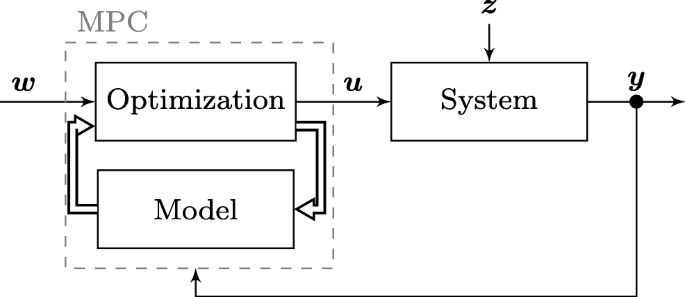

Желаемый результат $w$ - подается в оптимизатор, который выдает значение $u_0$, поступающее в заранее обученную эмулировать динамическую систему нейросетевую модель, она прогнозирует положение мячика на следующие несколько шагов (если говорить именно про нашу динамическую систему), после чего оптимизатор подбирает значение $u$, которое должен минимизировать функцию ошибку между желаемым выводом системы $w$ и предсказываемым моделью значением. После этого управляющий сигнал $u$ подается в саму динамическую систему. Повторяя данный цикл, контроллер осуществляет управление мячиком в магнитном поле.

Построим свой контроллер. Построим контроллер и научим нейросетевой модуль эмклировать поведение динамической системы.

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_103 (InputLayer)      [(None, 4, 1)]            0         
                                                                 
 flatten_102 (Flatten)       (None, 4)                 0         
                                                                 
 dense_43 (Dense)            (None, 8)                 40        
                                                                 
 dense_44 (Dense)            (None, 8)                 72        
                                                                 
 dense_45 (Dense)            (None, 1)                 9         
                                                                 
Total params: 121 (484.00 Byte)
Trainable params: 121 (484.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

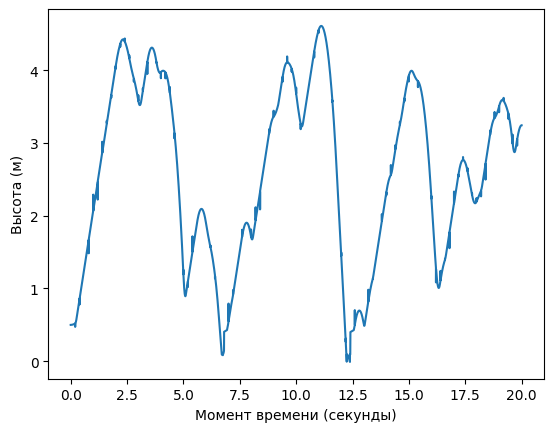

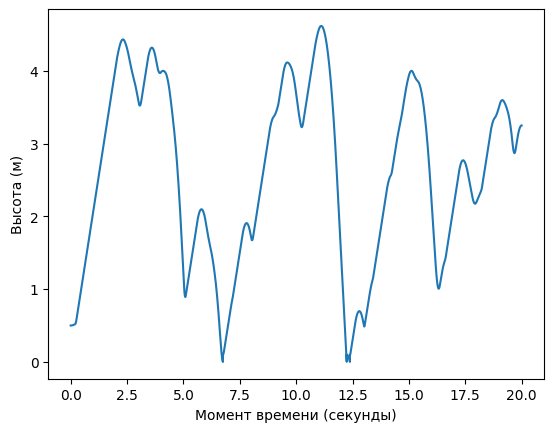

In [ ]:
# Функция ошибки
def lossf(x, ref, y, us):
        pass

# Оптимизатор в сети
class Optimizer:
    def __init__(self):
        pass

    def optimize(self, ref, y, prev_u):
        pass  # Метод оптимизации, не реализован

# НС для предсказания положения мячика
class NN:
    def __init__(self):
        self.model = NN.create_model()  # Создание экземпляра модели

    # Обучить НС
    def train(self, train_x, train_y):
        self.model.fit(train_x,
                       train_y,
                       epochs=10,
                       callbacks=[TqdmCallback(verbose=1)],
                       batch_size=32,
                       verbose=0)  # Обучение модели

    # Предсказание с помощью модели
    def predict(self, data):
        res = self.model.predict(data, verbose=0)
        return res

    # Создание модели
    @staticmethod
    def create_model() -> tf.keras.Model:
        input_layer_1 = Input((4, 1))
        f = Flatten()(input_layer_1)
        f = Dense(8, activation="relu")(f)
        f = Dense(8, activation="relu")(f)
        final_output = Dense(1, activation="linear")(f)
        model = tf.keras.Model(input_layer_1, final_output)
        # Компиляция модели с оптимизатором Adam и функцией потерь MSE
        model.compile(optimizer='adam', loss='mse')
        display(model.summary())  # Вывод краткого описания модели
        return model
# MPC контроллер
class MPC_Controller:
    def __init__(self):
        self.optimizer = Optimizer()
        self.nn = NN()

    # Обучение модели нейронной сети контроллера
    def train(self, train_x, train_y):
        self.nn.train(train_x, train_y)

    def predict(self, ref, pos, prev_pos, volt, prev_volt):
        u0 = self.optimizer.optimize(ref, pos, volt).x.flatten()[0]  # Оптимизация управляющего воздействия
        inp = np.array([u0, volt, pos, prev_pos]).reshape(-1, 4, 1)  # Подготовка входных данных для модели
        res = self.nn.predict(inp).flatten()[0]  # Предсказание с помощью нейронной сети
        u = self.optimizer.optimize(ref, res, volt).x.flatten()[0]  # Оптимизация управляющего воздействия
        return u  # Возврат оптимального управляющего воздействия

dt = 0.001
# Составление данных для обучения сети эмулировать дин. сист.
inp = np.array([[volt_data[i], volt_data[i-1], pos_data[i], pos_data[i-1]] for i in range(1, len(volt_data) - 1)])

controller = MPC_Controller()  # Создание экземпляра контроллера
controller.train(inp.reshape(-1, 4, 1), pos_data[2:])  # Обучение контроллера

# Составление данных для тестирования
inp = np.array([[volt_data0[i], volt_data0[i-1], pos_data0[i], pos_data0[i-1]] for i in range(1, len(volt_data0) - 1)])
# Отображение на графике реальных и предсказанных данных предсказанных данных
plt.plot(np.linspace(0, 19998 * dt, 19998), controller.nn.predict(inp.reshape(-1, 4, 1)).flatten())
plt.xlabel('Момент времени (секунды)')
plt.ylabel('Высота (м)')
plt.show()
plt.clf()
plt.xlabel('Момент времени (секунды)')
plt.ylabel('Высота (м)')
plt.plot(np.linspace(0, 19998 * dt, 19998), pos_data0[2:])
plt.show()


# Домашнее задание

## Условие:

Реализуйте ПИ-контроллер для системы с мячиком. Используйте ранее созданный класс `BallMagSystem`, симулирующий мячик. Протестируйте ваш контроллер на нескольких целевых значениях позиции мячика. Оцените производительность вашего контроллера и визуализируйте результаты.  
Целевые значения мячика: [2, 3, 5, 5, 2]

## Решение:

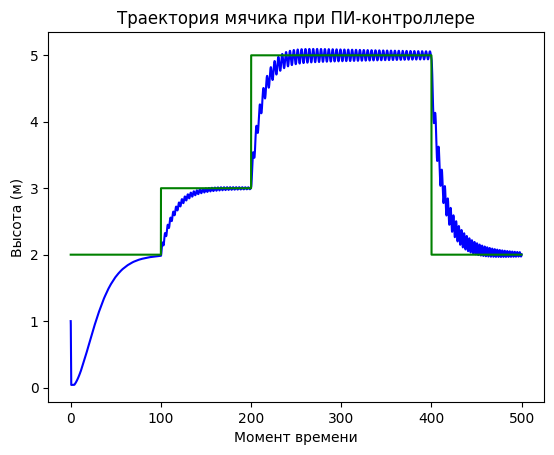

<Figure size 640x480 with 0 Axes>

In [ ]:
# Инициализация параметров PI-регулятора
# Коэффициент пропорциональной составляющей
Kp = 0.15  #@param {type:"slider", min:0, max:1, step:0.01}
# Коэффициент интегральной составляющей
Ki = 0.18  #@param {type:"slider", min:0, max:1, step:0.01}

# Функция для вычисления управляющего сигнала с помощью PI-регулятора
def pi_control(desired_position, current_position):
    global integral
    error = desired_position - current_position  # Вычисление текущей ошибки
    integral += error * dt  # Вычисление интеграла ошибок
    control_signal = Kp * error + Ki * integral  # Вычисление управляющего сигнала
    return control_signal  # Возвращение управляющего сигнала

# Функция для запуска моделирования системы с управлением PI-регулятором
def run_pi_controller(system, target, iter, dt):
    res = []  # Список для хранения управляющих сигналов
    positions = []  # Список для хранения текущих позиций
    for i in range(iter):
        pos = system.ball_pos  # Получение текущей позиции мячика
        signal = max(0, pi_control(target, pos))  # Вычисление управляющего сигнала и его ограничение
        curr_pos = BallMagSystem.simulated(system, signal)  # Моделирование движения системы с управляющим сигналом
        res.append(signal)  # Добавление управляющего сигнала в список
        positions.append(curr_pos)  # Добавление текущей позиции в список
    return res, positions  # Возвращение списков управляющих сигналов и текущих позиций


# Задание параметров моделирования
dt = 0.001  # Шаг по времени
n = 100000  # Количество итераций моделирования
target_positions = [2, 3, 5, 5, 2]  # Целевые значения позиции мячика

# Моделирование движения мячика с применением PI-контроллера
system = BallMagSystem()  # Создание объекта системы с мячиком
res_pi = []  # Список для хранения результатов моделирования
integral = 0  # Инициализация переменной для интегральной составляющей

# Цикл по целевым значениям позиции мячика
for target_pos in target_positions:
    # Запуск моделирования с управляющим сигналом PI-контроллера
    _, positions_pi = run_pi_controller(system, target_pos, n, dt)
    res_pi += positions_pi  # Добавление результатов моделирования в общий список

# Отображение траектории движения мячика с применением PI-контроллера
lin_space = np.linspace(0, n * len(target_positions) * dt, n * len(target_positions))
plt.plot(lin_space, res_pi, color="b")  # Отображение траектории мячика
plt.plot(lin_space, reference, color="g")  # Отображение целевых значений позиции мячика
plt.xlabel('Момент времени')  # Установка подписи оси x
plt.ylabel('Высота (м)')  # Установка подписи оси y
plt.title('Траектория мячика при ПИ-контроллере')  # Установка заголовка графика
plt.show()  # Отображение графика
plt.clf()  # Очистка текущего графика

# Ссылки

https://www.integrasources.com/blog/basics-of-pid-controllers-design-applications/  
https://www.mathworks.com/help/deeplearning/ug/design-narma-l2-neural-controller-in-simulink.html  
https://github.com/m-lundberg/simple-pid